<a href="https://colab.research.google.com/github/gardiens/mva_geom_24/blob/main/Copie_de_TP_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP1: Collection of Sentinel Images

---



### Name: **WRITE YOUR NAME HERE**

The objective of this session is to create a video of your house seen from space using satellite images freely available online. For that we are going to learn how to access and manipulate optical images from the Sentinel-2 satellites, and radar images from Sentinel-1. We will cover the following topics:
* coordinate reference systems, WGS84 (longitude/latitude), and projections (Mercator, UTM, EPSG codes)
* search and download images available at a given position
* image metadata, GeoTIFFs, and GDAL (gdalinfo)
* spectral bands and file formats

#### Instructions
To solve this TP, answer the questions below. Then export the notebook with the answers using the menu option **File->Download as->Notebook (.ipynb)**. Then [submit the resulting file here](https://kiwi.cmla.ens-cachan.fr/index.php/s/Q5ymNLQbGGKCgpq) by next week. You will receive an automatic acknowledgement of receipt.

The notes associated to this lesson are in [TP1.pdf](http://boucantrin.ovh.hw.ipol.im/static/facciolo/mvaisat/TP1.pdf).

There are **8 questions** in the notebook and corresponding text areas to fill-in the answers.

In [28]:
# Setup code for the notebook

# Execute code 'cells' like this by clicking on the 'Run'
# button or by pressing [shift] + [Enter].

# This cell only imports some python packages that will be
# used below. It doesn't generate any output.

# The following lines install the necessary packages in the colab environment
try:
    from google.colab import files

    # download TP data and tools
    !wget -q http://boucantrin.ovh.hw.ipol.im/static/facciolo/mvaisat/tp1.2.zip
    !unzip -q -o tp1.2.zip

    # install dependencies
    !apt-get -qq -o=Dpkg::Use-Pty=0 update && apt install -qq -o=Dpkg::Use-Pty=0 gdal-bin
    !python -m pip -q install rpcm rasterio
    !python -m pip -q install numpy utm python-dateutil tifffile shapely geojson enum34 features filelock matplotlib scipy pyproj scikit-image numba pillow opencv-contrib-python~=4.8.0.76  pandas setuptools srtm4 folium
    # install latest TSD
    !python -m pip -q install tsd==0.9.0
    #!pip install pypotree



except ImportError:
    %matplotlib notebook
    pass


## Setup code for the notebook
##
# Autoreload external python modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# These are the main includes used through the notebook
import datetime
import geojson
import numpy as np                   # numeric linear algebra
import matplotlib.pyplot as plt      # plotting
import rasterio       # read/write geotiffs
import tsd            # time series downloader for sentinel and landsat
import utils          # IO and coordinate system conversion tools
import vistools       # display tools
import folium
import folium.plugins

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
gdal-bin is already the newest version (3.6.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 55 not upgraded.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## A. Coordinate systems: longitude/latitude and UTM

* longitude/latitude and UTM coordinates
* convert from lon/lat to UTM and back
   - `utils.lonlat_to_utm(longitude, latitude, force_epsg=None)`: from lon/lat
   - `utils.utm_to_lonlat(easting, northing, epsg)`: to lon/lat
* interactive map tool for navigation
   - `vistools.foliummap(location=(lat,lon), zoom_start=13)`: creates an interactive map and returns a handle to modify it.

**Attention: the map widget use the latitude/longitude convention, which is the opposite to what we use in the utils package. This explains the reversed order  in m.location**

In [29]:
## First we use a map to find the coordinates of a region of interest

print('Select a rectangular region of interest on the interactive map and export it to download the corresponding geojson')

# these lines create a map and return a map handle, it's equivalent to
#     m = folium.Map()   # +  with widgets
m = vistools.foliummap(location = [48.841413, 2.328409])
# we can move the map to any position by indicating its (latitude, longitude)
m.location   = [48.841413, 2.328409]   # i.e. Paris, France
m.options['zoom'] = 13

display(m)

Select a rectangular region of interest on the interactive map and export it to download the corresponding geojson


**Copy the text of the exported polygon in the `geojsonstring` string below**

In [33]:
geojsonstring = """

COPY THE GEOJSON TEXT HERE

"""
#geojsonstring="""{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"LineString","coordinates":[[2.101735,48.792385],[2.101392,48.781579],[2.124607,48.780702],[2.125122,48.791282]]}},{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[2.112892,48.779089],[2.112892,48.790632],[2.128898,48.790632],[2.128898,48.779089],[2.112892,48.779089]]]}}]}"""

#  example polygons with other areas of interest
if "COPY THE GEOJSON TEXT HERE" in geojsonstring:
    geojsonstring = """
       { "type": "FeatureCollection",
        "features": [ {"type": "Feature",
        "geometry": {"coordinates":
                    [[[31.12624503672123, 29.97234031281746],
                    [31.12624503672123, 29.982786256861996],
                    [31.14066459238529, 29.982786256861996],
                    [31.14066459238529, 29.97234031281746],
                    [31.12624503672123, 29.97234031281746]]],
                    "type": "Polygon"}
        } ] }
        """

    # SF financial district:
    geojsonstring = """
        { "type": "FeatureCollection",
        "features": [ {"type": "Feature",
        "geometry": {"coordinates":
                    [[[-122.410056, 37.77979],
                    [-122.410056, 37.798578],
                    [-122.383276, 37.798578],
                    [-122.383276, 37.77979],
                    [-122.410056, 37.77979]]],
                    "type": "Polygon"}
        } ] }
        """

We only care about the `coordinates` in the `geometry` field so we extract it

In [34]:
# interpret the string as an object
geojsonstruct = geojson.loads(geojsonstring)

# this extracts the geometry field
aoi = utils.find_key_in_geojson(geojsonstruct,'geometry')

print("These are the coordinates of the selected polygon in GeoJSON format:")
print(geojson.dumps(aoi, indent=2))

These are the coordinates of the selected polygon in GeoJSON format:
{
  "type": "Polygon",
  "coordinates": [
    [
      [
        -122.410056,
        37.77979
      ],
      [
        -122.410056,
        37.798578
      ],
      [
        -122.383276,
        37.798578
      ],
      [
        -122.383276,
        37.77979
      ],
      [
        -122.410056,
        37.77979
      ]
    ]
  ]
}


In [35]:
m = vistools.foliummap()

# we can draw the aoi
folium.GeoJson(aoi).add_to(m)
# and center the map at the aoi center
m.location   = np.mean(aoi['coordinates'][0][:4], axis=0).tolist()[::-1]

display(m)

In [36]:
print("lat, lon: {}".format(m.location))

lat, lon: [37.789184, -122.39666600000001]


UTM coordinates are interesting because they are locally Euclidean.

**Exercise 1.** Implement the function `two_way_conversion_error` below, to convert (longitude, latitude) coordinates to UTM coordinates (easting, northing, and zone), then back to (longitude, latitude), and measure the resulting conversion error.

Use the `lonlat_to_utm` and `utm_to_lonlat` functions
from the `utils` module to convert to and from UTM.

_Note:_ be careful with the parameter conventions lon/lat vs lat/lon.

In [39]:
### Ex. 1

def two_way_conversion_error(lon, lat):
    """
    Compute the error after converting to UTM and back to lon, lat.

    Args:
        lon (float): longitude
        lat (float): latitude

    Returns:
        the difference between input lon, lat and lon, lat obtained
        after converting back and forth to UTM.
    """
    easting,northing,epsg=utils.lonlat_to_utm(lon,lat)
    lon2,lat2=utils.utm_to_lonlat(easting,northing,epsg)
    # compute the distance
    return np.array([lon-lon2,lat-lat2])


    ###### Insert your solution code here ######

The code in the cell below extracts the longitude, latitude of the center (location) of the map, and call your `two_way_conversion_error` function to measure the lon, lat --> UTM --> lon, lat conversion error.

In [40]:
# call your function
lat, lon = m.location
error = two_way_conversion_error(lon,lat)
np.testing.assert_allclose(error, np.zeros(2), atol=1e-9)
print(error)

[ 0.00000000e+00 -7.10542736e-15]


**Exercise 2.**
Trace a 200 km west-to-east line (with constant northing) in UTM coordinates with 10 samples.

Start at: `easting=400000; northing=5400000; epsg=32631`

1. Convert it to lon/lat and plot the resulting coordinates in a cartesian lon/lat plot.

2. Plot the same line on the map by using

```
    line = {'type': 'LineString', 'coordinates': [[-122.6, 37.], [..., ...], [-122., 37.]]}
    folium.GeoJson(line).add_to(m)
```


3. **Answer to the question:** What do you observe in the this experiment? Why?

Bear in mind these conclusions about the projections.

**Solution**

In [42]:
### Ex 2.

###### Insert your solution code here ######
easting=400000
northing=5400000
epsg=32631
eastings= [easting]+np.linspace(easting,easting+200e3,10)
northings=[northing]*10
lon,lat=utils.utm_to_lonlat(eastings,northings,epsg)
lon,lat


(array([7.07604442, 7.37708612, 7.67793844, 7.9785886 , 8.27902387,
        8.57923158, 8.87919913, 9.17891397, 9.47836363, 9.77753569]),
 array([48.68085747, 48.66979263, 48.65794358, 48.64531158, 48.63189796,
        48.61770415, 48.60273165, 48.58698206, 48.57045702, 48.5531583 ]))

In [44]:
###### Write your answer here ######
#display it
line={'type': 'LineString', 'coordinates': list(zip(lon,lat))}
folium.GeoJson(line).add_to(m)

display(m)

This is not a straight line?

## B. Query an image database for an AOI (area of interest)

We want to find all the available images over an area of interest (AOI). The Python package `tsd` (Time Series Downloader) allows to search for Sentinel-2 images on free online catalogs (such as CDSE, element84, planet...).

To query the online catalog for Sentinel-2 images, one can use the `tsd.get_sentinel2.search` function.

Each catalog entry is returned by `tsd` as a Python dictionary containing the image metadata. To display nicely the list of dictionaries, one may turn it into a `pandas.DataFrame`. There's plenty of data associated to each entry of the catalog. Take some time to see all the available keys of each image entry dict. Note that there is a cloud cover percentage estimation, and a thumbnail url.

In [45]:
# We shall use the following area of interest in the following experiments

if 1:
    # SF financial district:
    geojsonstring = """
        { "type": "FeatureCollection",
        "features": [ {"type": "Feature",
        "geometry": {"coordinates":
                    [[[-122.410056, 37.77979],
                    [-122.410056, 37.798578],
                    [-122.383276, 37.798578],
                    [-122.383276, 37.77979],
                    [-122.410056, 37.77979]]],
                    "type": "Polygon"}
        } ] }
        """
    geojsonstruct = geojson.loads(geojsonstring)
    aoi = utils.find_key_in_geojson(geojsonstruct,'geometry')

In [46]:
start_date = datetime.datetime(2023, 7, 1)
end_date = datetime.datetime(2023, 12, 31)

# run the query
image_catalog = tsd.get_sentinel2.search(aoi, start_date=start_date, end_date=end_date)

if len(image_catalog) == 0:
    print("Maybe your AOI selection is too large")

import pandas as pd
pd.DataFrame([dict(i) for i in image_catalog])

Found 37 images


,metadata_source,title,absolute_orbit,datatake_id,cloud_cover,thumbnail,geometry,mgrs_id,utm_zone,lat_band,sqid,epsg,date,relative_orbit,processing_level,satellite,filename,urls
0,cdse,S2B_MSIL2A_20230703T184919_N0509_R113_T10SEG_2...,33029,GS2B_20230703T184919_033029_N05.09,51.879489,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-07-03 18:49:19,113,2A,S2B,2023-07-03_S2B_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
1,cdse,S2A_MSIL2A_20230708T184921_N0509_R113_T10SEG_2...,42009,GS2A_20230708T184921_042009_N05.09,41.413921,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-07-08 18:49:21,113,2A,S2A,2023-07-08_S2A_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
2,cdse,S2B_MSIL2A_20230713T184939_N0509_R113_T10SEG_2...,33172,GS2B_20230713T184939_033172_N05.09,23.343851,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-07-13 18:49:39,113,2A,S2B,2023-07-13_S2B_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
3,cdse,S2A_MSIL2A_20230718T184921_N0509_R113_T10SEG_2...,42152,GS2A_20230718T184921_042152_N05.09,48.566011,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-07-18 18:49:21,113,2A,S2A,2023-07-18_S2A_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
4,cdse,S2B_MSIL2A_20230723T184929_N0509_R113_T10SEG_2...,33315,GS2B_20230723T184929_033315_N05.09,74.046761,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-07-23 18:49:29,113,2A,S2B,2023-07-23_S2B_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
5,cdse,S2A_MSIL2A_20230728T184921_N0509_R113_T10SEG_2...,42295,GS2A_20230728T184921_042295_N05.09,33.616892,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-07-28 18:49:21,113,2A,S2A,2023-07-28_S2A_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
6,cdse,S2B_MSIL2A_20230802T184919_N0509_R113_T10SEG_2...,33458,GS2B_20230802T184919_033458_N05.09,60.706621,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-08-02 18:49:19,113,2A,S2B,2023-08-02_S2B_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
7,cdse,S2A_MSIL2A_20230807T184921_N0509_R113_T10SEG_2...,42438,GS2A_20230807T184921_042438_N05.09,24.169014,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-08-07 18:49:21,113,2A,S2A,2023-08-07_S2A_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
8,cdse,S2B_MSIL2A_20230812T184919_N0509_R113_T10SEG_2...,33601,GS2B_20230812T184919_033601_N05.09,44.888464,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-08-12 18:49:19,113,2A,S2B,2023-08-12_S2B_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"
9,cdse,S2A_MSIL2A_20230817T184921_N0509_R113_T10SEG_2...,42581,GS2A_20230817T184921_042581_N05.09,44.664863,https://catalogue.dataspace.copernicus.eu/odat...,"{'type': 'Polygon', 'coordinates': [[[-123.000...",10SEG,10,S,EG,32610,2023-08-17 18:49:21,113,2A,S2A,2023-08-17_S2A_orbit_113_tile_10SEG_L2A,"{'aws': {}, 'gcloud': {}}"


The catalog contains the URL of each full image, thumbnail, and other information useful to filter the results before downloading the images.

To display an image in the notebook, use the `vistools.display_image` function:
- `vistools.display_image`: display images contained in np.arrays, files, or urls

In [47]:
## Let's select the last entry from the catalog
entry = image_catalog[-1]

# and display its thumbnail
vistools.display_image(entry['thumbnail'])   #  for displaying an image in the notebook
print('At any moment, about 60 percent of the earth is covered by clouds.')

At any moment, about 60 percent of the earth is covered by clouds.


**Exercise 3.**
Implement the function `query_clear_sky` according to the interface specified below. The function must query for Sentinel-2 images on the provided aoi and return only those with a cloud cover below the provided percentage.

**Hint:** access  fields from the registers using attributes i.e. `image_catalog[0].date`

**Solution**

In [48]:
### Ex 3.
def query_clear_sky(aoi, satellite='Sentinel-2', max_cloud_cover=30,
                    start_date=None, end_date=None):
    '''
    queries the devseed database for the aoi
    returns a filtered catalog with images with cloud
    cover of at most max_cloud_cover
    '''
    # run a search
    if satellite == 'Sentinel-2':
        res = tsd.get_sentinel2.search(aoi, start_date, end_date)
    elif satellite == 'Landsat-8':
        res = tsd.get_landsat.search(aoi, start_date, end_date)


    ###### Insert your solution code here ######
    print("the res",res)
    print(type(res))

    return res

The next cell tests your function by calling it on your AOI to search for images with cloud cover less than 20%, and displays the THUMBNAIL of all the images.

In [54]:
res = query_clear_sky(aoi, satellite='Sentinel-2', max_cloud_cover=20,
                      start_date=start_date,
                      end_date=end_date)

## display the images in a gallery
g, l = [], []
for p in res:
    l.append("Imaging date: {}, cloud cover: {}".format(p.date.isoformat(), p.cloud_cover))
    g.append(p.thumbnail)

vistools.display_gallery(g, l)

Found 37 images


## C. Downloading a full resolution image

Since the images are usually quite large (40k x 40k pixels, about 1GB) instead of downloading the entire images **tsd** (through GDAL) allows to download just a crop containing the desired AOI.

The `get_crop_from_aoi` function is a simplified interface to GDAL for cropping an AOI. Internally, it
* Extracts the url of the image from the catalog entry for the selected band
* Downloads a crop corresponding to the selected aoi
* Writes a GeoTIFF

The underlying function for cropping an image on the web is `tsd.utils.rasterio_geo_crop(output, inpath, ulx, uly, lrx, lry, epsg=None)`.

In this lower level function the aoi is specified using UTM bounding box coordinates `(ulx, uly, lrx, lry, epsg)` **but today we will only use it indirectly**.

In [50]:
def get_crop_from_aoi(output_path, aoi, catalog_entry, band):
    """
    Crop and download an AOI from a georeferenced image.
    Args:
        output_path (string): path to the output GeoTIFF file
        aoi (geojson.Polygon): area of interest defined by a polygon in longitude, latitude coordinates
        catalog_entry (tsd.s2_metadata_parser.Sentinel2Image): metadata object
        band (str): desired band, e.g. 'B04' for Sentinel-2 or 'B8' for Landsat-8
    """
    metadata = catalog_entry
    if not metadata.urls['aws']:
        metadata.build_s3_links()
    inpath = metadata.urls['aws'][band]

    utm_zone = metadata.get("utm_zone")
    lat_band = metadata.get("lat_band")
    epsg = tsd.utils.utm_to_epsg_code(utm_zone, lat_band) if utm_zone else None

    ulx, uly, lrx, lry, epsg = tsd.utils.utm_bbx(aoi, epsg=epsg, r=60)
    tsd.utils.rasterio_geo_crop(output_path, inpath, ulx, uly, lrx, lry, epsg=epsg)

Found 37 images
We can see some metadata...


({'driver': 'GTiff',
  'dtype': 'uint16',
  'nodata': 0.0,
  'width': 234,
  'height': 210,
  'count': 1,
  'crs': CRS.from_wkt('PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]'),
  'transform': Affine(10.0, 0.0, 551940.0,
         0.0, -10.0, 4183620.0)},
 BoundingBox(left=551940.0, bottom=4181520.0, right=554280.0, top=4183620.0))

...and the image. However it has a high bit depth so it cannot be shown as it is


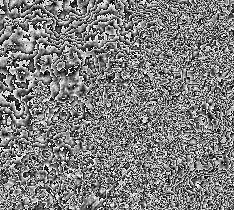

we can divide by 32 and see what happens


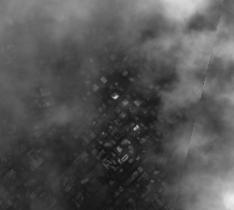

the result seems ok, but a bit dark


In [51]:
# Let's start downloading the green channel
my_satellite, band = 'Sentinel-2', 'B03'
fname = 'ex4_{}.tif'.format(band)
results = query_clear_sky(aoi, my_satellite, max_cloud_cover=30,
                          start_date=start_date, end_date=end_date)

# This is where the downloading is done
get_crop_from_aoi(fname, aoi, results[-1], band)

# To read the image and metadata useutils.readGTIFF andutils.readGTIFFmeta
im   = utils.readGTIFF(fname)
meta = utils.readGTIFFmeta(fname)

print('We can see some metadata...')
display(meta)
print('...and the image. However it has a high bit depth so it cannot be shown as it is')
vistools.display_image(im)
print('we can divide by 32 and see what happens')
vistools.display_image(im/32)
print('the result seems ok, but a bit dark')

## D. Read, write, and display images
* GeoTIFF and 8 bits formats (PNG and JPEG)
* read/write *GeoTIFF*s and its metadata:
  -  `utils.readGTIFF(fname)`:   Reads the image file `fname` into a numpy array,
    returns the numpy array with dimensions (height, width, channels)
  - `utils.readGTIFFmeta(fname)`: Reads the GeoTIFF metadata and returns a tuple
    containing the metadata and bounding box: (meta, bounds)
    if the file format doesn't support metadata the returned metadata is invalid.
  -  `utils.writeGTIFF(im, fname, copy_metadata_from=None)`:  Writes a numpy array to a *GeoTIFF*, *PNG*, or *JPEG* file depending on `fname` extension.
    For GeoTIFF files the metadata can be copied from another file (optional parameter).
    Note that if  `im`  and  `copy_metadata_from` have different size,
    the copied geolocation properties are not adapted.
* display a numpy array with a color palette:
  - `vistools.display_imshow(out,[0,1], cmap="jet")`: display the `[0,1]` range using the `jet` palette
* assemble color images from bands
* compute a multispectral vegetation index: NDVI

**Exercise 4.**
The TIFF images can have a high dynamic range. To display them on
the screen we must map them to 8bits.
Write a program that affinely maps a high dynamic range image to
8bits (0 to 255). Determine the range of the input data and set
the saturation values at X and (100-X) percentile of the image.
Implement the function `simple_equalization_8bit` according to the interface specified below.


```python
def simple_equalization_8bit(im, percentiles=5):
    ''' im is a numpy array
        returns a numpy array
    '''

    ###     <<< CODE HERE >>>

    return im  # return equalized image
```

**Solution**

In [52]:
### Ex 4.

###### Insert your solution code here ######

This cell tests the above function.

In [53]:
#### Test the function by calling it with
basename='ex4_'
im = utils.readGTIFF(basename+'B03.tif')
vistools.display_image(
    simple_equalization_8bit(im, percentiles=2)
)

NameError: name 'simple_equalization_8bit' is not defined

In [ ]:
#  Let's write a function that downloads the Sentinel-2 RGB bands
#  and creates an 8bit color image. For that we will apply the function
#  simple_equalization_8bit to each channel.

def get_sentinel2_color_8bit(basefilename, aoi, catalog_entry, percentiles=5):
    ''' basefilename to store the bands:  basename+BAND+'.tif'
        returns a numpy array of the RGB image (height, width, channels)
    '''
    bands = ['B02', 'B03', 'B04']    # SENTINEL2 R,G,B BANDS

    # this command downloads all the bands
    for b in bands:
        get_crop_from_aoi('{}_{}.tif'.format(basefilename, b), aoi, catalog_entry, b)

    # read, equalize, and stack all the channels
    out = []
    for b in bands:
        im = utils.readGTIFF('{}_{}.tif'.format(basefilename, b))
        im = simple_equalization_8bit(im, percentiles)
        out.append(im)

    # The transposition is necessary because the indexing
    # convention for color images is (height, width, channels)
    im = np.squeeze(out,axis=(3)).transpose(1,2,0)
    return im


#### Test the function by running
# pick the satellite then query the database
my_satellite = 'Sentinel-2'
basename = 'rgb'
res = query_clear_sky(aoi, my_satellite, max_cloud_cover=10, start_date=start_date, end_date=end_date)

# generate the RGB image
RGBout = get_sentinel2_color_8bit(basename, aoi, res[-1])

# Writes RGBout in 'rgb_RGB.tif' copying geolocation metadata from 'rgb_B03.tif',
# which has been written by    get_sentinel2_color_8bit
utils.writeGTIFF(RGBout[:,:,0:3], basename+'_RGB.tif', basename+'_B03.tif')

# display RGBout
vistools.display_imshow(RGBout[:,:,0:3], figsize=(10,10))

**Exercise 5.**
  Multi-spectral images allow to measure things that are otherwise non visible.
  By using the NIR and RED bands, the normalized difference vegetation index (NDVI)
  (https://en.wikipedia.org/wiki/Normalized_difference_vegetation_index) can assess
  whether the observed target contains live green vegetation or not.
  More on NDVI: https://phenology.cr.usgs.gov/ndvi_foundation.php
  Other indices can be found here:
  * http://www.sentinel-hub.com/apps/wms/wms-parameters/EOproducts
  * https://www.indexdatabase.de/db/ias.php

Let us compute and display the NDVI index on the AOI to find the parks and forests in a the area.
Implement the function `get_sentinel2_NDVI` according to the interface specified below.


```python
def get_sentinel2_NDVI(basefilename, aoi, catalog_entry):
    '''
    basefilename: to store the bands:  basename+BAND+'.tif'
    aoi: is the area of interest
    catalog_entry: is the register of a query
    returns a numpy array
    '''

    ###     <<< CODE HERE >>>

    return NDVI  # NDVI image (numpy array)
```

**Solution**

In [ ]:
### Ex 5.

###### Insert your solution code here ######

The following lines allow to test the function.
This command:

      display_imshow(NDVI, [0,1], cmap="jet")
is used to show the array mapping the range [0,1] using the 'jet' colormap

In [ ]:
# pick the satellite then query the database
my_satellite = 'Sentinel-2'
basename = 'ex5'
res = query_clear_sky(aoi, my_satellite, max_cloud_cover=10, start_date=start_date, end_date=end_date)

out = get_sentinel2_NDVI(basename, aoi, res[-1])

utils.writeGTIFF(out, basename+'_NDVI.tif', basename+'B08.tif')

vistools.display_imshow(out, [0,1], cmap="jet", figsize=(10,10))

## E. Time series
* Downloading crops of all the images for an AOI could be done with the tools presented so far:

  `tsd.get_sentinel2.search` and `get_crop_from_aoi`.

  But, we provide the following function to simplify the task of searching and downloading all the images on the `aoi`:

   - `tsd.get_sentinel2.get_time_series(aoi, out_dir='tmp', bands=['B04'])`

* Make an animated gif

In [ ]:
# FIRST REMOVE THE OUTPUT FILES FROM PREVIOUS RUNS
!rm -rf tmp/*.tif.png* tmp/*.tif

# Download all the image for a satellite over an aoi
tsd.get_sentinel2.get_time_series(aoi, out_dir='tmp', bands=['B03'], start_date=start_date, end_date=end_date)

import glob

# list the donwloaded files
#print (glob.glob('tmp/*.tif') )


# select the green band 'B03' (sentinel), or panchromatic '8' (landsat)
# then read tiff and convert them to png (geolocation information is lost)
for i in  glob.glob('tmp/*_B8.tif') + (glob.glob('tmp/*B03.tif')):
    im = utils.readGTIFF( i )
    im = simple_equalization_8bit(im,  percentiles=2)
    utils.writeGTIFF(im,'%s.png'%i)
    vistools.overprintText('%s.png'%i,'%s.png'%i,i[4:-4],textRGBA=[0,255,0,255])


# create an animated gif
vistools.make_animated_gif('tmp/timeseries.gif', 'tmp/*.tif.png')

vistools.display_image('tmp/timeseries.gif')

### SAR time series

* obverve the modulus of an SLC radar image in a time series
* SLC images appear stretched in the azimuth direction (flight direction)

In [ ]:
## The files 'data/SF/SanFranciscoRadar{01-48}.tif' form a time series of sentinel-1 images
## the images are georeferenced and are already real with 8-bits values

import glob
# generate PNG
imgs=glob.glob('data/SF/SanFranciscoRadar??.tif')
for i in imgs:
    utils.writeGTIFF(utils.readGTIFF(i),i[:-3]+'png')
# display the result
imgs=sorted(glob.glob('data/SF/SanFranciscoRadar??.png'))
vistools.display_gallery(imgs)

**Exercise 6.**
  Simple denoising. Write a program to remove some of the noise by using the fact that the images are aligned.
  The simplest denoising consists in taking the average, however the geometric mean (
$ \left(\prod _{i=1}^{n}x_{i}\right)^{\frac {1}{n}} $)
  is more appropriate for the type of noise present in SAR images.

Implement the function `geometric_mean_images` according to the interface specified below.


```python
def geometric_mean_images(imgs_names_list):
    '''
    receives a list of image filenames
    returns a numpy array with the pixel-wise geometric mean
    '''

    ###     <<< CODE HERE >>>

    return gm
```

**Solution**

In [ ]:
### Ex 6.

###### Insert your solution code here ######

In [ ]:
#### Test the function by running
import glob
imgs=sorted(glob.glob('data/SF/SanFranciscoRadar??.tif'))

vistools.display_image(
    simple_equalization_8bit(
        geometric_mean_images(imgs)
    ))

## F. Reprojection

* determine the geographic coordinates (longitude, latitude, and altitude wrt the WGS84 reference
    ellipsoid) corresponding to an image coordinate (in pixels)
  - `utils.gdal_get_longlat_of_pixel(fname, x, y )`: returns the long/lat (at 0 altitude) for the points at pixel coordinates (x, y) of the image fname.
* resample (or reproject) a GeoTIFF in longitude, latitude coordinates
  - `utils.gdal_resample_image_to_longlat(fname, outfname)`: reproject GeoTIFF image in the long/lat image CRS

**Exercise 7.**
Determine the geographic coordinates (longitude, latitude) of the
 four corners of the SAR image and draw a polygon on a map.
 Write the function `get_image_longlat_polygon` following the prototype below and use provided test code.


```python
def get_image_longlat_polygon(filename):
    '''
    receives a GeoTIFF filename. Determines the image size
    and computes the long/lat coordinates of the four image corners.
    returns a GeoJSON polygon with the four corners
    '''

    ###     <<< COMPLETE THE CODE >>>

    return polygon
```

**Hint:** use  `utils.gdal_get_longlat_of_pixel`

**Hint2:** make sure to use `utils.readGTIFFmeta`  in order to determine the
         size of the image. It is much faster than reading the whole image

**Solution**

In [ ]:
### Ex 7.

###### SOLUTION ######

def get_image_longlat_polygon(filename):
    '''
    receives a GeoTIFF filename. Determines the image size
    and computes the long/lat coordinates of the four image corners.
    returns a GeoJSON polygon with the four corners
    '''
    # get the image size
    A = utils.readGTIFFmeta(filename)
    H = int(A[0]['height'])
    W = int(A[0]['width'])

    cols = [0,W,W,0]
    rows = [0,0,H,H]

    ###     <<< COMPLETE THE CODE >>>

    # remove the altitude (which is 0)
    coords = [ [x[0], x[1]] for x in coords ]

    polygon = {'type': 'Polygon', 'coordinates': [coords]}
    return polygon


In [ ]:
#### Test the function by running
fname = 'data/SF/SanFranciscoRadar01.tif'

footprint = get_image_longlat_polygon(fname)

# create a map cetered at location indicated by its (latitude, longitude)
m = vistools.foliummap(location = footprint[ 'coordinates'][0][0][::-1],
                       zoom_start = 13 )
# and display the footprint polygon
folium.GeoJson(footprint).add_to(m)

display(m)

In [ ]:
##  Now we can reproject the image in geographic coordinates (longitude, latitude)
##  using utils.gdal_resample_image_to_longlat, then compute the footprint of the
##  reprojected image and display the result on a map.

img = 'data/SF/SanFranciscoRadar01.tif'

# Reproject the image in longlat (one GeoTIFF and one PNG)
utils.gdal_resample_image_to_longlat(img, 'tmp/sarimage_longlat.tif')

# Extract the new image footprint from the GeoTIFF
footprint2 = get_image_longlat_polygon('tmp/sarimage_longlat.tif')
print (footprint2)

# Convert TIFF to 8-bits and write a PNG
data = utils.readGTIFF('tmp/sarimage_longlat.tif')
utils.writeGTIFF( simple_equalization_8bit( data ), 'tmp/sarimage_longlat.png' )

# Display the reprojected PNG overlaid on a map at the coordinates of the footprint
m = vistools.foliummap(location = footprint2[ 'coordinates'][0][0][::-1],
                        zoom_start = 13)

# first show the footprint
folium.GeoJson(footprint2).add_to(m)

# then compute the bounding box of the image footprint
lon, lat, Dlon, Dlat = utils.bounding_box2D( footprint2[ 'coordinates'] )

# then add the image overlay at the bounding box location
folium.raster_layers.ImageOverlay(image   = 'tmp/sarimage_longlat.png',
                                  bounds  = [[lat + Dlat, lon + Dlon ] ,
                                             [lat       , lon] ],
                                  opacity = 0.7).add_to(m)

folium.LayerControl().add_to(m)

display(m)

**Exercise 8.**
Read the GeoTIFF `data/fin.tif`, and overlay it on the map at its correct position and orientation

**Solution**

In [ ]:
### Ex 8.

img = 'data/fin.tif'


###### SOLUTION ######



## Reproject the image in longlat (one GeoTIFF and one PNG)
utils.gdal_resample_image_to_longlat(img, 'tmp/ex10_longlat.tif')

# Extract the new image footprint from the GeoTIFF
footprint3 = get_image_longlat_polygon('tmp/ex10_longlat.tif')
print(footprint3)

# Convert TIFF to 8-bits and write a PNG
data =  utils.readGTIFF('tmp/ex10_longlat.tif')
utils.writeGTIFF( simple_equalization_8bit( data ), 'tmp/ex10_longlat.png' )


# Display the reprojected PNG overlaid on a map at the coordinates of the footprint
m = vistools.foliummap(location = footprint3[ 'coordinates'][0][0][::-1],
                        zoom_start = 13)

folium.GeoJson(footprint3).add_to(m)

lon, lat, Dlon, Dlat = utils.bounding_box2D( footprint3[ 'coordinates'] )

folium.raster_layers.ImageOverlay(image   = 'tmp/ex10_longlat.png',
                                bounds  = [[lat + Dlat, lon + Dlon ] ,
                                            [lat       , lon] ],
                                opacity = 0.7).add_to(m)


folium.LayerControl().add_to(m)

display(m)



---------------------------
[//]: # (© 2018 Gabriele Facciolo)
[//]: # (<div style="text-align:center; font-size:75%;"> Copyright © 2018 Gabriele Facciolo. All rights reserved.</div> )